In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from constants import m_mw_dm
from scipy.integrate import quad, dblquad, trapz
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import binom, norm, poisson
from scipy import special
from pbhhalosim import PBHHaloSim

Notes/questions/to-do
* In the case of $f \sim 10^{-4} - 10^{-2}$, which is more constraining: $\gamma$-ray point source or diffuse constraints? When can each be used?
* Need to make sure the detectable PBHs aren't too close to Earth! **Otherwise they could contribute to the local DM density.**
* **`efficient_angular_sampling`** seems to be failing for low PBH masses

# Setting constraints

In [28]:
def fit_fermi_uaps(m_pbh, f_pbh, m_dm, n_u, flux_thresh, b_cut, flux_type,
                   n_samples=5000, efficient_angular_sampling=True,
                   truncate_radial_samples=True):
    """Determines the value of <sigma v> fitting the Fermi unassociated point
    source (UAPS) catalogue.
    
    Parameters
    ----------
    m_pbh : float
        PBH mass, M_sun.
    f_pbh : float
        Omega_PBH / Omega_CDM.
    m_dm : float
        DM mass, GeV.
    n_u : int or float
        Number of PBHs allowed to appear in the UAPS catalogue.
        
    Return
    ------
    Best-fit value for <sigma v>, cm^3/s.
    """
    def objective(sv):
        sim = PBHHaloSim(mass_dist=m_pbh, f_pbh=f_pbh, m_dm=m_dm, sv=sv, b_cut=b_cut,
                         flux_thresh=flux_thresh, n_samples=n_samples,
                         flux_type=flux_type)
        sim.run(efficient_angular_sampling, truncate_radial_samples)
        return sim.n_det - n_u
    
    return root_scalar(objective, bracket=[1e-50, 1e-26], x0=1e-30, xtol=1e-99, rtol=1e-5)

In [29]:
# Load p(f | m_pbh, n^03) from Bradley
m_pbh = 0.5  # M_sun
if m_pbh == 10:
    f_pbhs, p_f_1, p_f_10, p_f_100 = np.loadtxt(
        "../SilverBulletsForWIMPs/results/posteriors_f/Posterior_f_ET_M=%.1f.txt" %
        m_pbh).T
elif m_pbh in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    f_pbhs, p_f_1, p_f_10, p_f_100 = np.loadtxt(
        "../SilverBulletsForWIMPs/results/posteriors_f/Posterior_f_M=%.1f.txt" % m_pbh).T

# Number of gravitational wave detections
n_gw_dets = np.array([1., 10., 100.])
f_pbh_maps = {1.: f_pbhs[np.argmax(p_f_1)],
              10.: f_pbhs[np.argmax(p_f_10)],
              100.: f_pbhs[np.argmax(p_f_100)]}

# DM masses at which to compute <sigma v> constraint
m_dms = np.logspace(1, 3, 5)
# Assumed number of PBHs in the UAPS catalogue. This and the detectability
# cuts are from Hooper's revised subhalo analysis, arxiv:1610.07587, page 12.
n_u = 19
flux_type = "dnde"
flux_thresh = 7e-10  # cm^-2 s^-1
b_cut = 20.

In [37]:
# Compute new constraints
sv_constraints = {}
n_tot_fn_calls = 0
for n_gw_det in n_gw_dets:
    svs = []
    for m_dm in m_dms:
        sol = fit_fermi_uaps(m_pbh, f_pbh_maps[n_gw_det], m_dm, n_u,
                             flux_thresh, b_cut, flux_type, n_samples=10000)
        if sol.converged == True:
            svs.append(sol.root)
        else:
            print("Solver did not converged")
            svs.append(np.nan)
        print("# function calls = {}".format(sol.function_calls))
        n_tot_fn_calls += sol.function_calls
    sv_constraints[n_gw_det] = np.array(svs)
print("Total # function calls = {}".format(n_tot_fn_calls))

# Load previous constraints
# sv_constraints = {}
# for n_gw_det in n_gw_dets:
#     sv_constraints[n_gw_det] = np.loadtxt(
#         "data/sv_lim_M=%.1f_n=%i_fs=b_cuts=1610.07587.csv" % (m_pbh, n_gw_det))

# function calls = 20
# function calls = 24
# function calls = 20
# function calls = 20
# function calls = 17
# function calls = 12
# function calls = 20
# function calls = 22
# function calls = 22
# function calls = 18
# function calls = 23
# function calls = 20
# function calls = 25
# function calls = 18
# function calls = 25
Total # function calls = 306
CPU times: user 6.47 s, sys: 32.1 ms, total: 6.5 s
Wall time: 6.5 s


Inefficient radial sampling:
* Total # function calls = 318
* CPU times: user 48.7 s, sys: 4.32 s, total: 53 s
* Wall time: 53.1 s

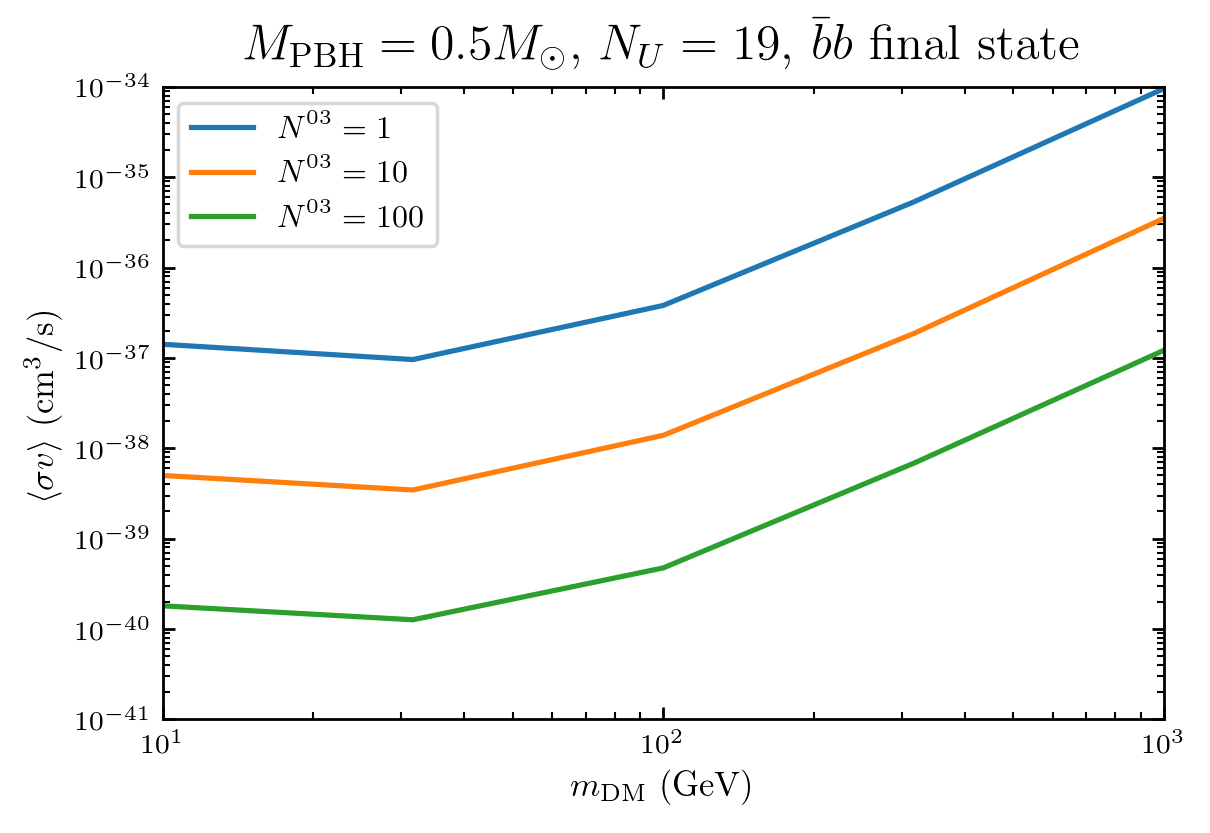

In [38]:
for n_gw_det in n_gw_dets:
    plt.plot(m_dms, sv_constraints[n_gw_det], label=r"$N^{03} = %i$" % n_gw_det)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title(r"$M_{\mathrm{PBH}} = %.1f M_\odot$, $N_U=%i$, $\bar{b} b$ final state" %
          (m_pbh, n_u))
plt.tick_params(axis='both', which='both', top=True, right=True, direction="in")
plt.xlim(m_dms[[0, -1]])
plt.axhline(3e-26, linestyle='--', color='k', alpha=0.5)
# plt.text(4e2, 2e-27, r"$\langle \sigma v \rangle_{\mathrm{thermal}}$")
# plt.ylim(1e-41, 1e-23)

# LIGO 03, 0.5M_sun
plt.ylim(1e-41, 1e-34)
# Einstein telescope
# plt.ylim(1e-36, 2e-31)

plt.legend()
plt.tight_layout()
# plt.savefig("figures/et_M=%.1f_limits_v1.pdf" % m_pbh)

In [ ]:
os.system("say 'Done!'")

In [21]:
for n_gw_det in n_gw_dets:
    np.savetxt("data/sv_lim_M=%.1f_n=%i_fs=b_cuts=1610.07587.csv" % (m_pbh, n_gw_det),
               sv_constraints[n_gw_det])

# Examine fluxes and number of detectable point sources

## Testing correctness of efficient sampling

In [5]:
n_det_pbhs = []
n_det_pbhs_err = []
m_pbhs = np.logspace(-1, 2, 20)  # M_sun
m_dm = 100  # GeV
sv = 3e-26  # cm^3/s
fluxes = []

for m_pbh in m_pbhs:
    s = PBHHaloSim(mass_dist=m_pbh, f_pbh=1e-8, m_dm=m_dm, sv=sv,
                   flux_type="dnde", fs="b", b_cut=20, flux_thresh=7e-10,
                   n_samples=100000)
    s.run(efficient_angular_sampling=True, truncate_radial_samples=True)
    n_det_pbhs.append(s.n_det)
    n_det_pbhs_err.append(s.n_det_err)
    fluxes.append(s.fluxes)

n_det_pbhs = np.array(n_det_pbhs)
n_det_pbhs_err = np.array(n_det_pbhs_err)
fluxes = np.array(fluxes)

<ErrorbarContainer object of 3 artists>

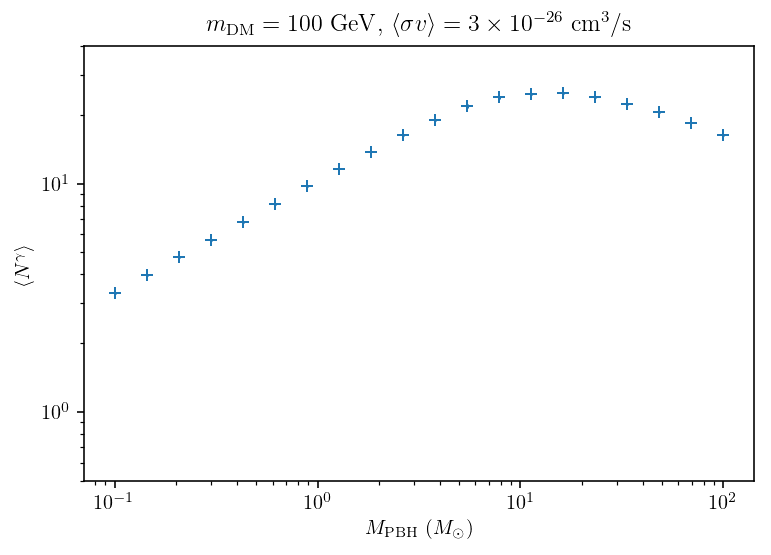

In [6]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$M_{\mathrm{PBH}}$ ($M_\odot$)")
plt.ylabel(r"$\langle N^\gamma \rangle$")
plt.title(r"$m_{\mathrm{DM}} = 100~\mathrm{GeV}$, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}~\mathrm{cm}^3/\mathrm{s}$")
plt.ylim(5e-1, 4e1)

plt.errorbar(m_pbhs, n_det_pbhs, yerr=n_det_pbhs_err, fmt="+")

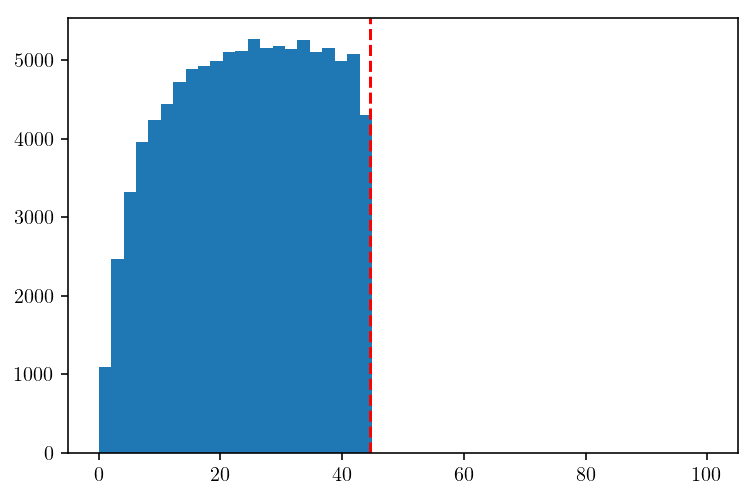

In [7]:
# Examining sampled radial positions
plt.hist(s.positions_abs[0], bins=np.linspace(0, 100))
plt.axvline(8.33 + s.d_ms[0], linestyle='--', color='r')

Text(0.5, 1.0, '$m_{\\mathrm{DM}} = 100~\\mathrm{GeV}$, $\\langle \\sigma v \\rangle = 3\\times 10^{-26}~\\mathrm{cm}^3/\\mathrm{s}$')

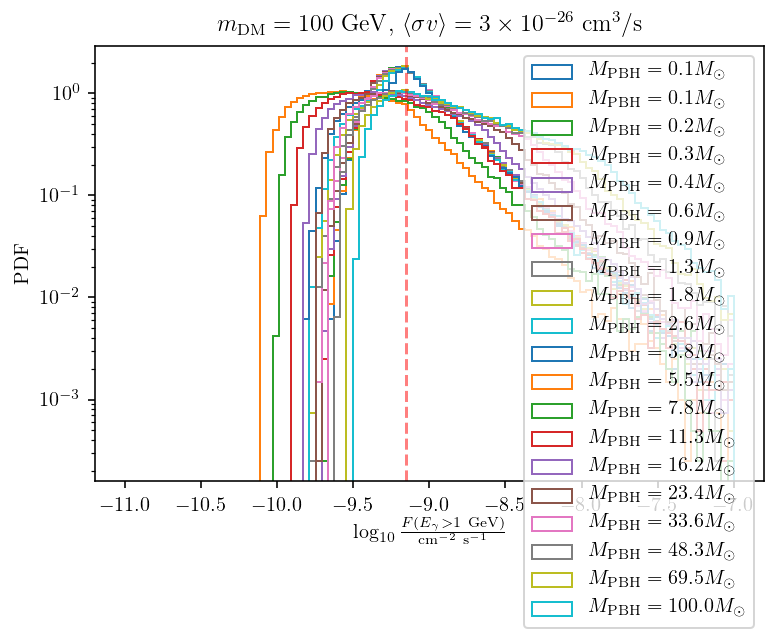

In [15]:
# NOTE: this plot is only correct when efficient_angular_sampling is False!
for m_pbh, f in zip(m_pbhs, fluxes):
    plt.hist(np.log10(f), bins=np.linspace(-11, -7, 100), density=True,
             histtype="step", label=r"$M_{\mathrm{PBH}} = %.1f M_\odot$" % m_pbh)
    
plt.axvline(np.log10(s.flux_thresh), color='r', linestyle='--', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.xlabel(r"$\log_{10} \frac{F(E_\gamma > 1~\mathrm{GeV})}{\mathrm{cm}^{-2}~\mathrm{s}^{-1}}$")
plt.ylabel("PDF")
plt.title(r"$m_{\mathrm{DM}} = 100~\mathrm{GeV}$, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}~\mathrm{cm}^3/\mathrm{s}$")

## Trying to fit flux distribution analytically

**Note:** this plot is only correct when `efficient_angular_sampling` is `False`!

Text(0.5, 1.0, '$m_{\\mathrm{DM}} = 100~\\mathrm{GeV}$, $\\langle \\sigma v \\rangle = 3\\times 10^{-26}~\\mathrm{cm}^3/\\mathrm{s}$')

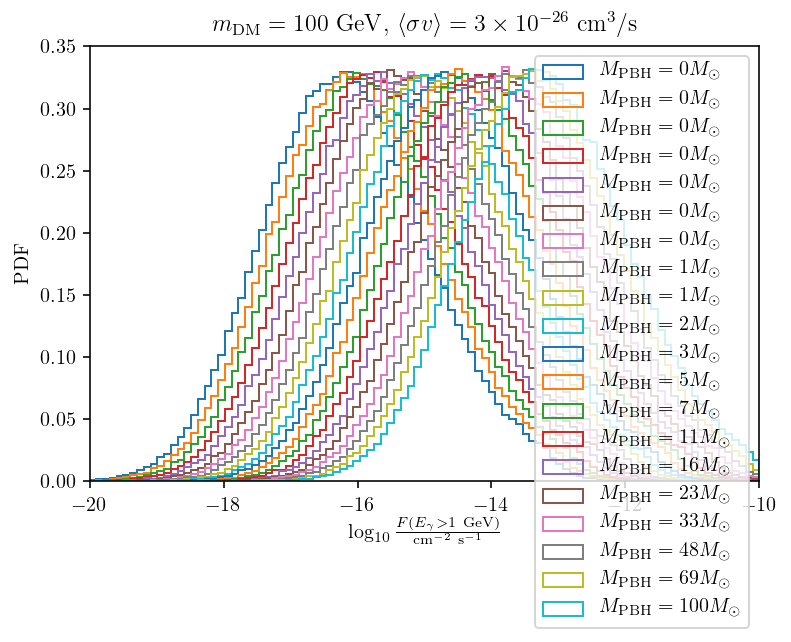

In [394]:
for m_pbh, f in zip(m_pbhs, fluxes):
    plt.hist(np.log10(f), bins=np.linspace(-20, -10, 100), density=True,
             histtype="step", label=r"$M_{\mathrm{PBH}} = %i M_\odot$" % m_pbh)
    
plt.xlim(-20, -10)
plt.legend()
plt.xlabel(r"$\log_{10} \frac{F(E_\gamma > 1~\mathrm{GeV})}{\mathrm{cm}^{-2}~\mathrm{s}^{-1}}$")
plt.ylabel("PDF")
plt.title(r"$m_{\mathrm{DM}} = 100~\mathrm{GeV}$, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}~\mathrm{cm}^3/\mathrm{s}$")

Studying scaling of flux distribution

In [492]:
rs = np.random.gamma(shape=3/alpha_mw,
                     scale=alpha_mw*r_s_mw**alpha_mw/2,
                     size=1000000)**(1/alpha_mw)

-2*np.mean(np.log(rs))

-11.129136986435627

In [491]:
-2*np.mean(np.log(rs))

-11.126712273197498

In [478]:
int_e_dnde_interps["b"](1000) / int_e_dnde_interps["b"](100)

11.634427901749843

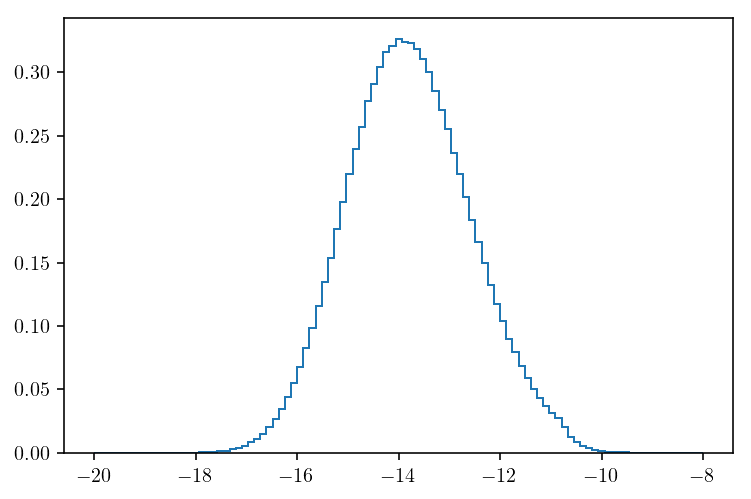

In [484]:
bins = np.linspace(-20, -8, 100)
plt.hist(np.log10(fluxes[0]), histtype="step", density=True, bins=bins);

# Computing posteriors

In [3]:
# Load p(f | m_pbh, n^03) from Bradley
m_pbh = 0.5  # M_sun
if m_pbh == 10:  # Einstein telescope
    f_pbhs, p_f_1, p_f_10, p_f_100 = np.loadtxt(
        "../SilverBulletsForWIMPs/results/posteriors_f/Posterior_f_ET_M=%.1f.txt" %
        m_pbh).T
elif m_pbh in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:  # LIGO 03
    f_pts, p_f_1_pts, p_f_10_pts, p_f_100_pts = np.loadtxt(
        "../SilverBulletsForWIMPs/results/posteriors_f/Posterior_f_M=%.1f.txt" % m_pbh).T

# Number of gravitational wave detections
n_gws = np.array([1., 10., 100.])
def p_f(f, n_gw):
    if n_gw == 1:
        p_f_pts = p_f_1_pts
    elif n_gw == 10:
        p_f_pts = p_f_10_pts
    elif n_gw == 100:
        p_f_pts = p_f_100_pts
    else:
        raise ValueError("Invalid number of GW detections")
    return np.interp(f, f_pts, p_f_pts)

# Assumed number of PBHs in the UAPS catalogue. This and the detectability
# cuts are from Hooper's revised subhalo analysis, arxiv:1610.07587, page 12.
n_u = 19
flux_type = "dnde"
flux_thresh = 7e-10  # cm^-2 s^-1
b_cut = 20.

Text(0.5, 1.0, '$M_{\\mathrm{PBH}} = 0.5~M_\\odot$')

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


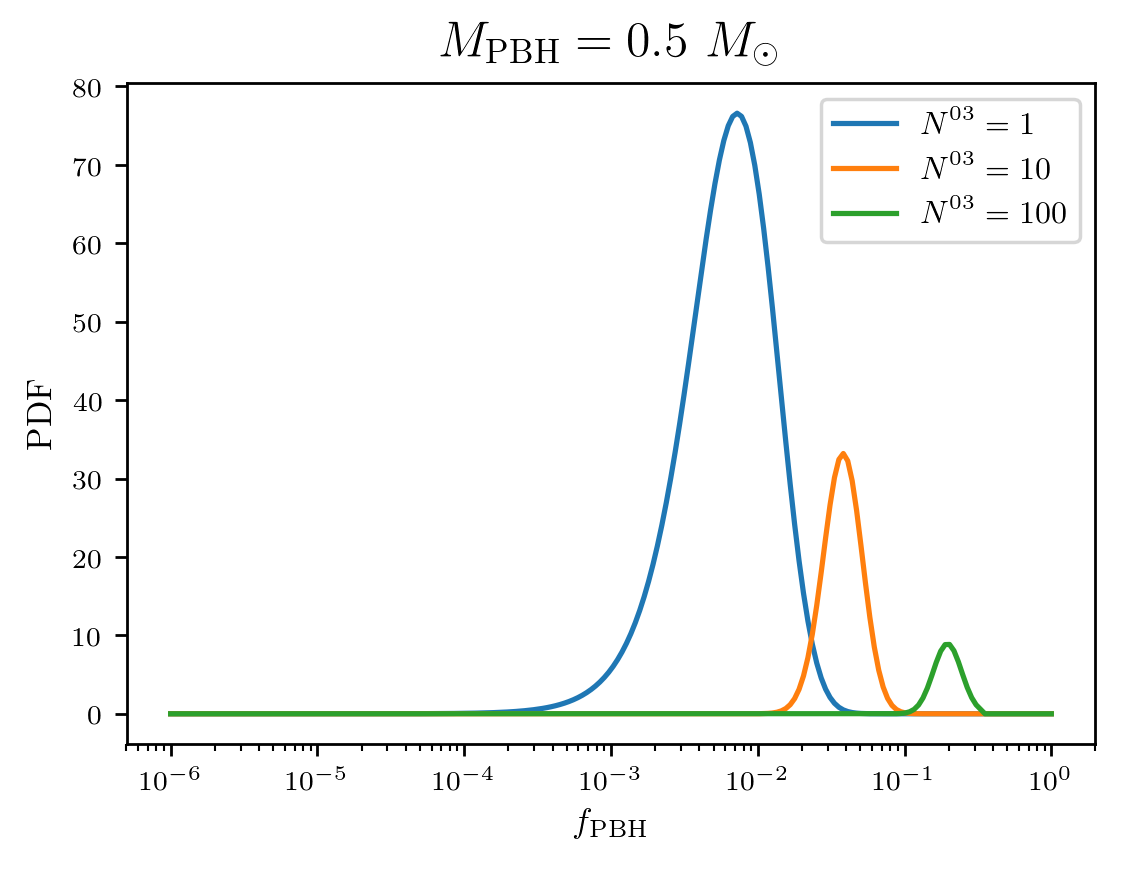

In [5]:
for n_gw in n_gws:
    plt.plot(f_pts, p_f(f_pts, n_gw), label=r"$N^{03} = %i$" % n_gw)
plt.xscale('log')
plt.xlabel(r"$f_{\mathrm{PBH}}$")
plt.ylabel("PDF")
plt.legend()
plt.title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$" % m_pbh)

To get this working, focus on $N^{03} = 1$. 
* Take $f \in [10^{-4}, 10^{-1}]$, since that's where $p(f)$ has most of its mass.
* Take $m_{\mathrm{DM}} = 100$ GeV
* Make a grid for $\langle \sigma v \rangle$ over $[10^{-39}, 10^{-35}]$ cm$^3$/s

In [4]:
m_dm = 100
sv_pts = np.logspace(-50, -20, 400)

def p_sv(sv):  # prior on <sigma v>
    return 1

def n_mw_pbhs(f, m_pbh=m_pbh):
    return f * m_mw_dm / m_pbh

Want to compute $p_\gamma(M_{\mathrm{PBH}}, m_{\mathrm{DM}}, \langle \sigma v \rangle)$

In [5]:
def get_p_gamma(sv, m_pbh=m_pbh, m_dm=m_dm, n_samples=50000):
    def helper(sv):
        sim = PBHHaloSim(mass_dist=m_pbh, f_pbh=1, m_dm=m_dm, sv=sv,
                         flux_type=flux_type, b_cut=b_cut, flux_thresh=flux_thresh,
                         n_samples=n_samples)
        sim.run()
        return sim.pr_det
    return np.vectorize(helper)(sv)

In [6]:
p_gamma_pts = get_p_gamma(sv_pts)
p_gamma = interp1d(sv_pts, p_gamma_pts)

In [1]:
np.savetxt("data/p_gamma_mdm=%i_M=%.1f.csv" % (m_dm, m_pbh),
           np.array([sv_pts, p_gamma_pts]).T,
           header=("p_gamma for m_dm=%i, M_pbh=%.1f.\n"
                   "Columns are: <sigma v> (cm^3/s), p_gamma." % (m_dm, m_pbh)))

NameError: name 'np' is not defined

In [7]:
def p_n_gamma(n_gamma, sv, f, norm_approx=False):
    if norm_approx:
        # Normal approx. to binomial
        n = n_mw_pbhs(f)
        p = p_gamma(sv)
        return norm.pdf(loc=n*p, scale=n*p*(1-p))
    else:
        return binom.pmf(n_gamma, n=np.floor(n_mw_pbhs(f)), p=p_gamma(sv))

In [8]:
def p_lam(lam):
    return 1 / np.sqrt(lam)

def p_u(n_u, n_gamma):
    def helper(n_gamma):
        if n_u > n_gamma:
            # Assuming a Jeffreys' prior lam^{-1/2}:
            n_a = n_u - n_gamma
            return special.gamma(n_a + 1/2) / special.gamma(n_a + 1)
        else:
            return 0
    return np.vectorize(helper)(n_gamma)

In [9]:
def integrand(sv, n_gamma, f, n_gw=1, n_u=n_u):
    return p_sv(sv) * p_f(f, n_gw) * p_n_gamma(n_gamma, sv, f) * p_u(n_u, n_gamma)

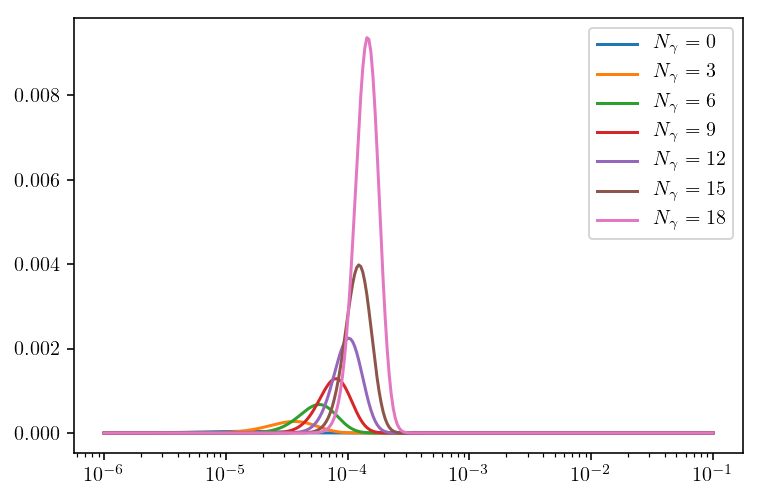

In [10]:
fs = np.logspace(-6, -1, 300)

for n_gamma in np.arange(0, 19, 3):
    plt.plot(fs, integrand(1e-33, n_gamma, fs), label=r"$N_\gamma=%i$" % n_gamma)

plt.xscale("log")
plt.legend()

In [25]:
def posterior_sv(sv):
    return dblquad(lambda ng, f: integrand(sv, ng, f),
                   f_pts[0], f_pts[-1], lambda f: 0, lambda f: n_u,
                   epsabs=1e-99)

Text(0.5, 1.0, '$M_{\\mathrm{PBH}} = 0.5~M_\\odot$')

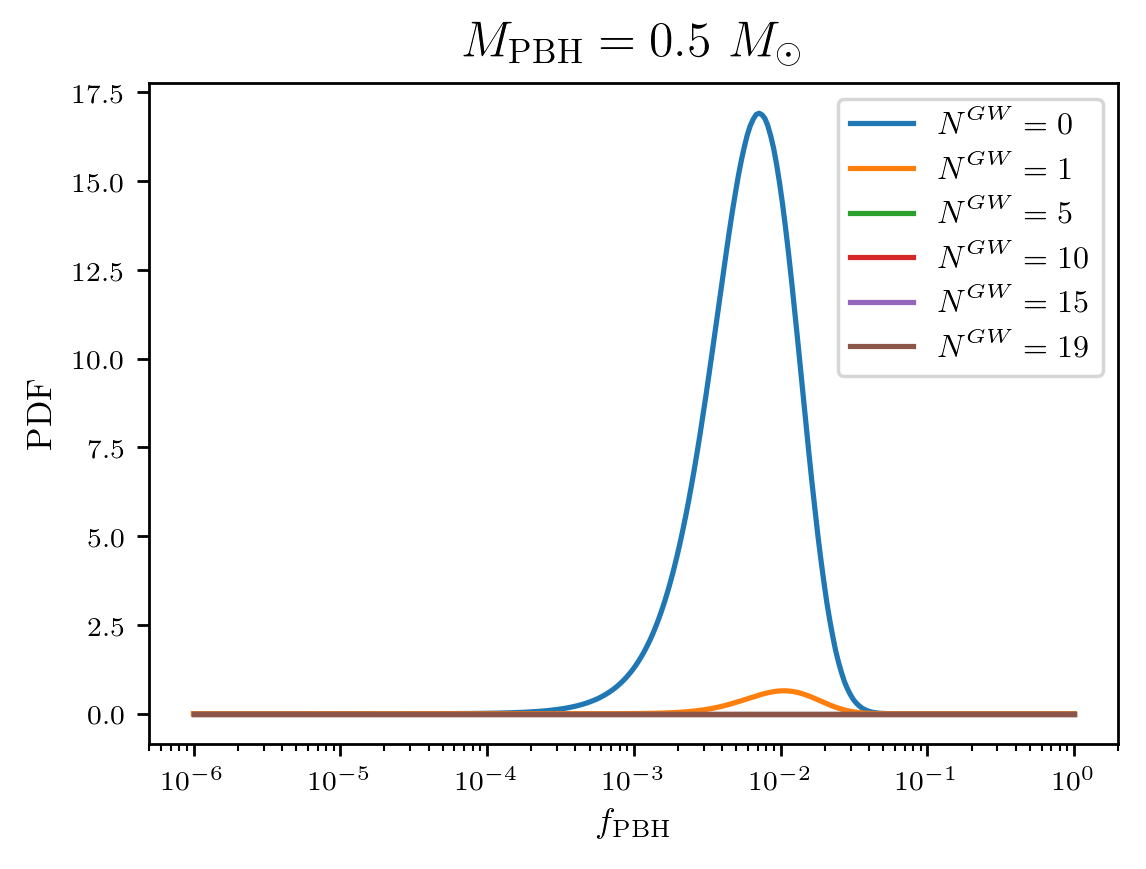

In [92]:
fs = np.logspace(np.log10(f_pts[0]), np.log10(f_pts[-1]), 300)

for ng in [0, 1, 5, 10, 15, 19]:
    plt.plot(fs, integrand(1e-42, ng, fs), label=r"$N^{GW}=%i$" % ng)

plt.xscale("log")
plt.xlabel(r"$f_{\mathrm{PBH}}$")
plt.ylabel("PDF")
plt.legend()
plt.title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$" % m_pbh)

In [70]:
# sv_pts
n_gammas = np.arange(0, n_u+1)
# fs = np.logspace(np.log10(f_pts[0]), np.log10(f_pts[-1]), 1000)
n_gamma_mg, f_mg = np.meshgrid(n_gammas, fs)

In [80]:
posterior_vals = []
for sv in sv_pts:
    posterior_vals.append(0)
    for n_g in n_gammas:
        posterior_vals[-1] += quad(lambda f: integrand(sv, n_g, f),
                                   5e-5, 0.1, epsabs=1e-99)[0]
posterior_vals = np.array(posterior_vals)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected


In [237]:
np.savetxt("data/posterior_M=0.5_mdm=100_N=1_LIGO_03.csv",
           np.array([np.concatenate((np.array([0]), sv_pts)),
           np.concatenate((np.array([posterior_vals[0]]),
                           posterior_vals)) / norm_const]).T,
           header=("p(sv | n_pbh, n_u) for m_dm=%i, M_pbh=%.1f, N_PBH=1 at LIGO 03.\n"
                   "Columns are: <sigma v> (cm^3/s), p." % (m_dm, m_pbh)))

In [158]:
# Normalize the posterior
posterior_unnormed = interp1d(np.concatenate((np.array([0]), sv_pts)),
                              np.concatenate((np.array([posterior_vals[0]]),
                                              posterior_vals)),
                              bounds_error=True)
norm_const = quad(posterior_unnormed, 0, 1e-34, epsabs=1e-99, limit=100)[0]
post_sv = interp1d(np.concatenate((np.array([0]), sv_pts)),
                   np.concatenate((np.array([posterior_vals[0]]),
                                   posterior_vals)) / norm_const,
                   bounds_error=True)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


Define the upper bound at level $\alpha$ as the value $\langle \sigma v \rangle_\alpha$ such that

$$\int_0^{\langle \sigma v \rangle_\alpha} d\langle \sigma v \rangle\ p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U}) = \alpha.$$

In [182]:
def credible_interval(posterior, level, x_min, x_max, x_guess):
    def objective(x):
        return quad(posterior, x_min, x, epsabs=1e-99, limit=100)[0] - level
    return root_scalar(objective, bracket=[x_min, x_max], x0=x_guess, xtol=1e-99).root

In [183]:
sv_upper_bound = credible_interval(post_sv, 0.95, 0, 1e-34, 1e-35)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing imports until


-0.95 0.0499999999999996


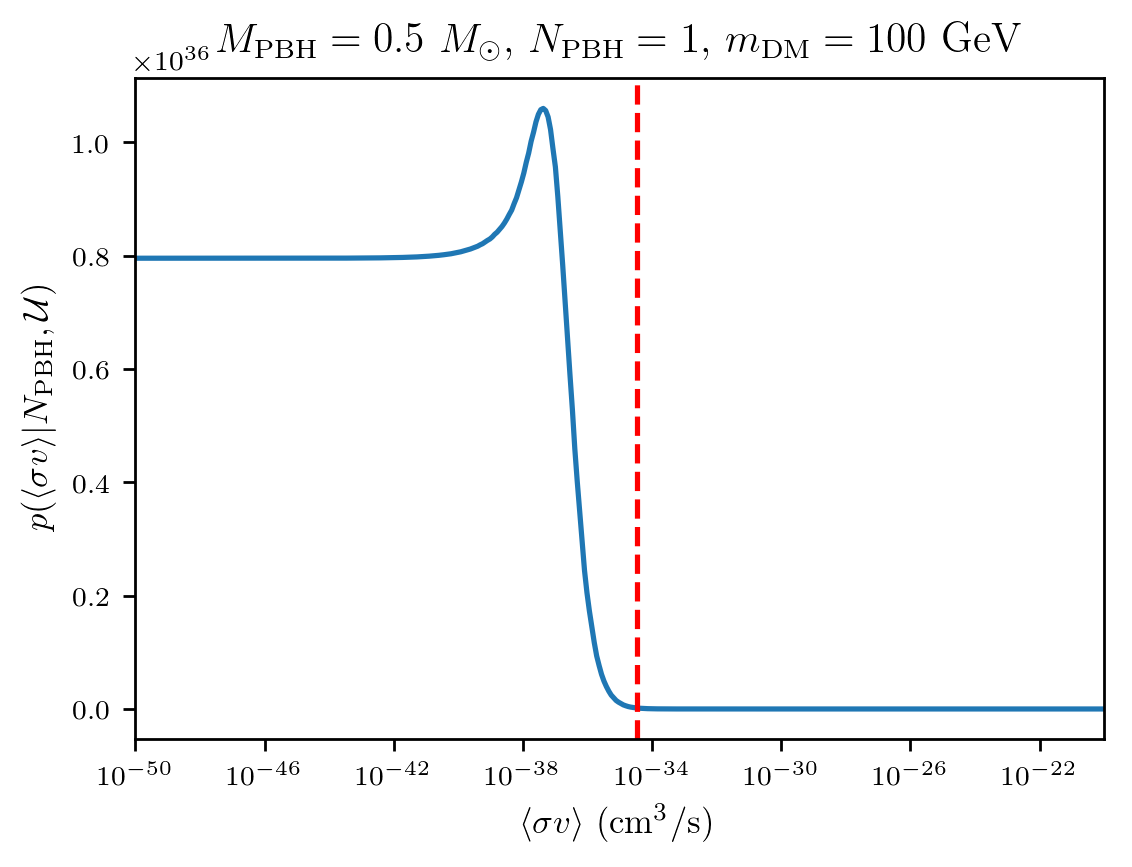

In [212]:
plt.plot(sv_pts, post_sv(sv_pts))
plt.axvline(sv_upper_bound, color='r', linestyle='--')
plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
           r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dm), fontsize=12)
plt.xlim(sv_pts[[0, -1]])
plt.savefig("figures/posterior_example.pdf")

In [ ]:
os.system("say 'Done'")

sv in 1e-45, 1e-28